## Segmentation Data - Legend

The dataset consists of information about the purchasing behavior of 2,000 individuals from a given area when entering a physical 'FMCG' store. All data has been collected through the loyalty cards they use at checkout. The data has been preprocessed, and there are no missing values. In addition, the volume of the dataset has been restricted and anonymized to protect the privacy of the customers.

### Variable Descriptions

| Variable        | Data type   | Range        | Description                                                                                     |
|-----------------|-------------|--------------|-------------------------------------------------------------------------------------------------|
| ID              | numerical   | Integer      | Shows a unique identifier of a customer.                                                        |
| Sex             | categorical | {0, 1}       | Biological sex (gender) of a customer. In this dataset, there are only 2 different options.   |
|                 |             |              | 0: Male                                                                                        |
|                 |             |              | 1: Female                                                                                      |
| Marital status  | categorical | {0, 1}       | Marital status of a customer.                                                                  |
|                 |             |              | 0: Single                                                                                      |
|                 |             |              | 1: Non-single (divorced / separated / married / widowed)                                      |
| Age             | numerical   | Integer      | The age of the customer in years, calculated as current year minus the year of birth.         |
|                 |             |              | Min value: 18 (the lowest age observed in the dataset)                                        |
|                 |             |              | Max value: 76 (the highest age observed in the dataset)                                       |
| Education       | categorical | {0, 1, 2, 3} | Level of education of the customer.                                                            |
|                 |             |              | 0: Other / Unknown                                                                             |
|                 |             |              | 1: High School                                                                                 |
|                 |             |              | 2: University                                                                                  |
|                 |             |              | 3: Graduate School                                                                             |
| Income          | numerical   | Real         | Self-reported annual income in US dollars of the customer.                                    |
|                 |             |              | Min value: 35,832 (the lowest income observed in the dataset)                                 |
|                 |             |              | Max value: 309,364 (the highest income observed in the dataset)                               |
| Occupation      | categorical | {0, 1, 2}   | Category of occupation of the customer.                                                        |
|                 |             |              | 0: Unemployed / Unskilled                                                                      |
|                 |             |              | 1: Skilled Employee / Official                                                                 |
|                 |             |              | 2: Management / Self-employed / Highly Qualified Employee / Officer                           |
| Settlement size | categorical | {0, 1, 2}   | The size of the city that the customer lives in.                                              |
|                 |             |              | 0: Small City                                                                                  |
|                 |             |              | 1: Mid-sized City                                                                              |
|                 |             |              | 2: Big City                                                                                    |


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import plotly.io as pio
import plotly.express as px


from sklearn.decomposition import PCA
import pickle

import warnings 
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')


In [2]:
df_ = pd.read_csv('../data/raw/Segmentation data.csv', index_col=[0])
df = df_.copy()

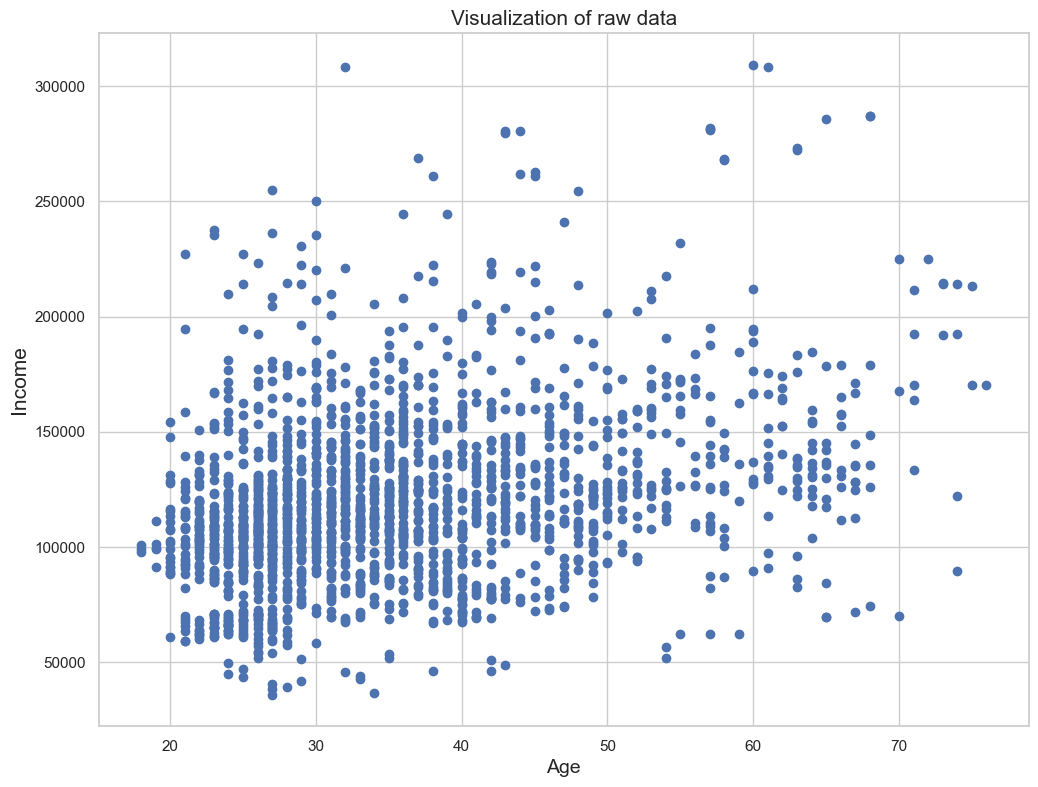

In [3]:
plt.figure(figsize = (12, 9))
plt.scatter(x = df.loc[:, 'Age'], y = df.loc[:, 'Income'])
plt.xlabel('Age', fontsize = 14)
plt.ylabel('Income', fontsize = 15)
plt.title('Visualization of raw data', fontsize = 15)
plt.savefig('../reports/figures/raw_data.png')
plt.show()

In [4]:
scaler = StandardScaler()
df_std = scaler.fit_transform(df)

In [5]:
hier_clust = linkage(df_std, method = 'ward')

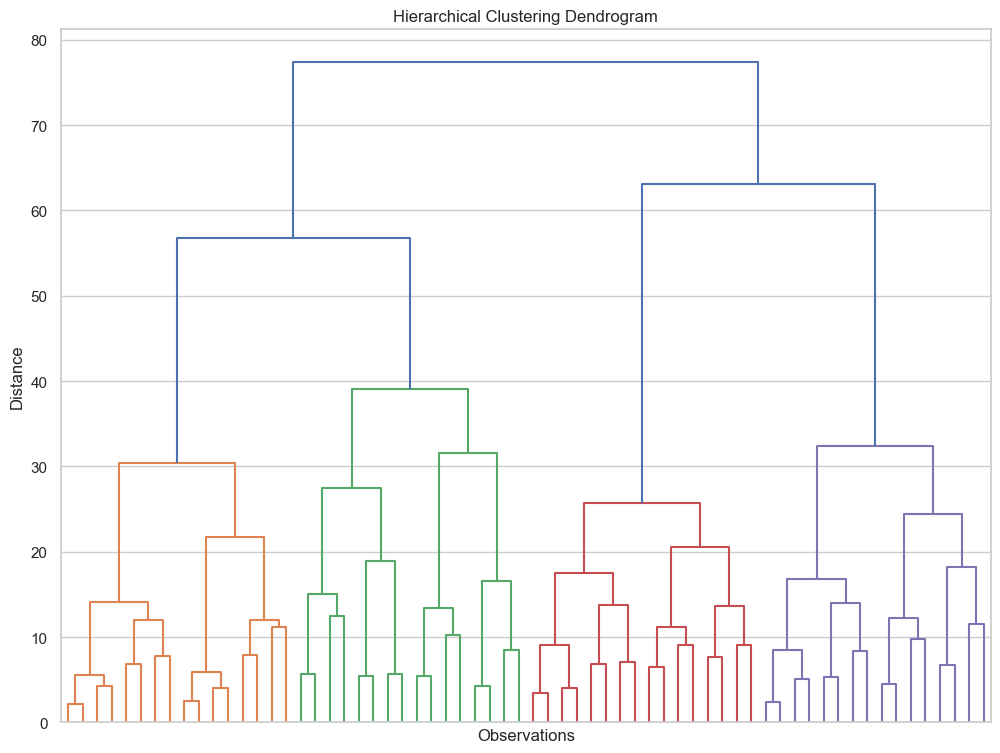

In [6]:
plt.figure(figsize = (12,9))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
dendrogram(hier_clust,
           truncate_mode = 'level',
           p = 5,
           show_leaf_counts = False,
           no_labels = True)
plt.savefig('../reports/figures/Hierachical_clustering.png')
plt.show()

## ${\textbf{K-means Clustering}}$

In [7]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(df_std)
    wcss.append(kmeans.inertia_)

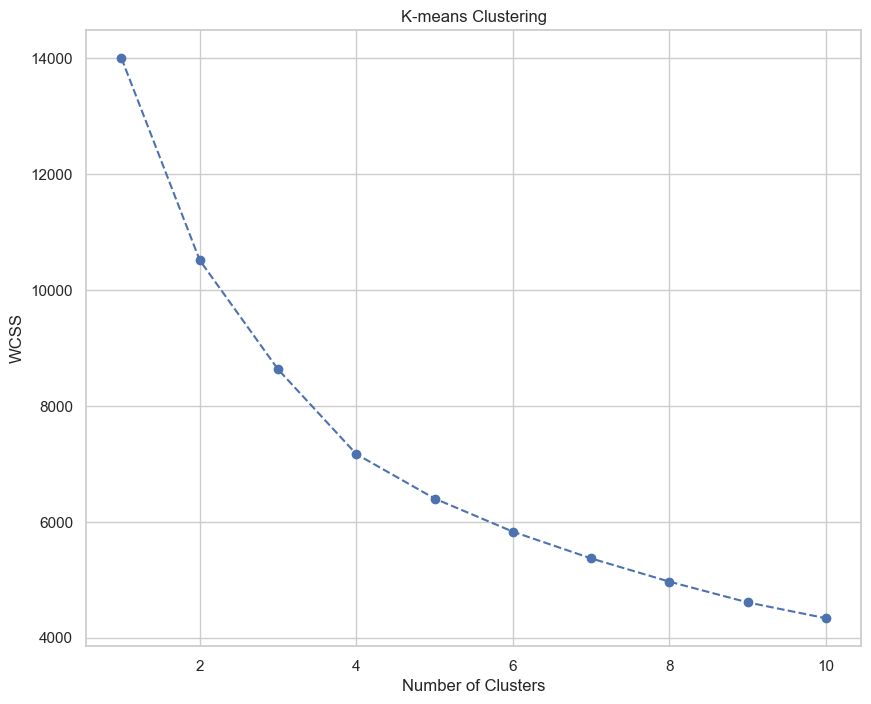

In [8]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.savefig('../reports/figures/wcss.png')
plt.show()

In [9]:
kmeans = KMeans(n_clusters = 5, random_state = 42).fit(df_std)

In [10]:
labels = kmeans.labels_
db_score = davies_bouldin_score(df_std, labels)

print("The Davies-Bouldin score is :", db_score)

The Davies-Bouldin score is : 1.3097034632486184


In [11]:
df_segm_kmeans = df.copy()
df_segm_kmeans['Segment K-means'] = labels
df_segm_kmeans.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment K-means
ID,,,,,,,,
100000001,0,0,67,2,124670,1,2,4
100000002,1,1,22,1,150773,1,2,0
100000003,0,0,49,1,89210,0,0,2
100000004,0,0,45,1,171565,1,1,3
100000005,0,0,53,1,149031,1,1,3


In [12]:
df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means']).mean()
df_segm_analysis['N Obs'] = df_segm_kmeans[['Segment K-means','Sex']].groupby(['Segment K-means']).count()
df_segm_analysis['Prop Obs'] = df_segm_analysis['N Obs'] / df_segm_analysis['N Obs'].sum()
df_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N Obs,Prop Obs
Segment K-means,,,,,,,,,
0,0.660167,0.983287,28.172702,1.013928,127151.857939,1.130919,1.309192,359,0.1795
1,0.834034,1.000000,30.733193,1.123950,97098.056723,0.399160,0.004202,476,0.2380
2,0.362031,0.000000,35.527594,0.743929,98133.229581,0.335541,0.041943,453,0.2265
3,0.004274,0.000000,36.927350,0.675214,141806.596154,1.252137,1.512821,468,0.2340
4,0.467213,0.672131,56.143443,2.147541,160749.204918,1.176230,1.143443,244,0.1220


In [13]:
cluster_names = {
    0: "Young Professionals",
    1: "Struggling Young Adults",
    2: "Middle-aged and Moderate",
    3: "Affluent Middle-aged",
    4: "Senior and Affluent"
}


In [14]:
df_segm_analysis.rename(cluster_names)

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N Obs,Prop Obs
Segment K-means,,,,,,,,,
Young Professionals,0.660167,0.983287,28.172702,1.013928,127151.857939,1.130919,1.309192,359,0.1795
Struggling Young Adults,0.834034,1.000000,30.733193,1.123950,97098.056723,0.399160,0.004202,476,0.2380
Middle-aged and Moderate,0.362031,0.000000,35.527594,0.743929,98133.229581,0.335541,0.041943,453,0.2265
Affluent Middle-aged,0.004274,0.000000,36.927350,0.675214,141806.596154,1.252137,1.512821,468,0.2340
Senior and Affluent,0.467213,0.672131,56.143443,2.147541,160749.204918,1.176230,1.143443,244,0.1220


### Cluster Analysis for K-means Clustering

The K-means clustering algorithm has identified five clusters based on the features in the dataset. Below are the characteristics of each cluster, along with the cluster names and explanations:

#### Cluster 0: "Young professionals"

- Sex: 0.66 (Female dominant)
- Marital Status: 0.98 (Mostly non-single)
- Age: 28.17 (Relatively young)
- Education: 1.01 (High school to university)
- Income: $127,152 (Moderate to high income)
- Occupation: 1.13 (Skilled employee / official)
- Settlement Size: 1.31 (Mid-sized city)
- Number of Observations: 359 (17.95% of total observations)

Explanation: Cluster 0 represents individuals who are relatively young, predominantly female, and mostly non-single. They have moderate to high income levels and are often skilled employees or officials, residing in mid-sized cities. This segment is characterized as "Young and Aspiring," as they are likely early in their careers and working towards building a stable financial foundation.

#### Cluster 1: "Struggling Young Adults"

- Sex: 0.83 (Female dominant)
- Marital Status: 1.00 (All non-single)
- Age: 30.73 (Young adults)
- Education: 1.12 (High school to university)
- Income: $97,098 (Moderate income)
- Occupation: 0.40 (Unemployed / unskilled)
- Settlement Size: 0.00 (Small city)
- Number of Observations: 476 (23.80% of total observations)

Explanation: Cluster 1 comprises young adults, predominantly female, who are mostly non-single. They have a moderate income but face challenges in employment, with a significant portion being unemployed or in unskilled occupations. Their residences are typically in small cities. This segment is referred to as "Struggling Young Adults," as they are likely navigating employment uncertainties and financial limitations.

#### Cluster 2: "Middle-aged and Moderate"

- Sex: 0.36 (Male dominant)
- Marital Status: 0.00 (All single)
- Age: 35.53 (Middle-aged)
- Education: 0.74 (Other / unknown to high school)
- Income: $98,133 (Moderate income)
- Occupation: 0.34 (Unemployed / unskilled)
- Settlement Size: 0.04 (Small to mid-sized city)
- Number of Observations: 453 (22.65% of total observations)

Explanation: Cluster 2 consists of middle-aged individuals, predominantly male, who are single. They have a moderate income but may have uncertain employment prospects, with a notable proportion being unemployed or in unskilled occupations. Their residences are typically in small to mid-sized cities. This segment is named "Middle-aged and Moderate," as they represent a middle-aged group with relatively modest financial standing.

#### Cluster 3: "Affluent Middle-aged"

- Sex: 0.00 (Male dominant)
- Marital Status: 0.00 (All single)
- Age: 36.93 (Middle-aged)
- Education: 0.68 (Other / unknown to high school)
- Income: $141,807 (High income)
- Occupation: 1.25 (Skilled employee / official)
- Settlement Size: 1.51 (Big city)
- Number of Observations: 468 (23.40% of total observations)

Explanation: Cluster 3 comprises middle-aged individuals, predominantly male, who are single. They have a high income and are often skilled employees or officials, residing in big cities. This segment is labeled "Affluent Middle-aged," as they enjoy high income levels and are likely in senior positions in their careers.

#### Cluster 4: "Senior and Affluent"

- Sex: 0.47 (Male dominant)
- Marital Status: 0.67 (Mostly non-single)
- Age: 56.14 (Seniors)
- Education: 2.15 (University to graduate school)
- Income: $160,749 (High income)
- Occupation: 1.18 (Skilled employee / official)
- Settlement Size: 1.14 (Mid-sized city)
- Number of Observations: 244 (12.20% of total observations)

Explanation: Cluster 4 comprises senior individuals, predominantly male, who are often non-single. They have a high income and are typically skilled employees or officials, residing in mid-sized cities. This segment is referred to as "Senior and Affluent," as they are well-established in their careers and enjoy a high income, likely in their retirement years.

The clusters represent different demographic and income groups, and the assigned cluster names provide insights into the characteristics of each segment based on the K-means clustering results.


In [15]:

# Map the cluster names to the cluster numbers in the original DataFrame
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment K-means'].map(cluster_names)

df_segm_kmeans.head()


,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment K-means,Labels
ID,,,,,,,,,
100000001,0,0,67,2,124670,1,2,4,Senior and Affluent
100000002,1,1,22,1,150773,1,2,0,Young Professionals
100000003,0,0,49,1,89210,0,0,2,Middle-aged and Moderate
100000004,0,0,45,1,171565,1,1,3,Affluent Middle-aged
100000005,0,0,53,1,149031,1,1,3,Affluent Middle-aged


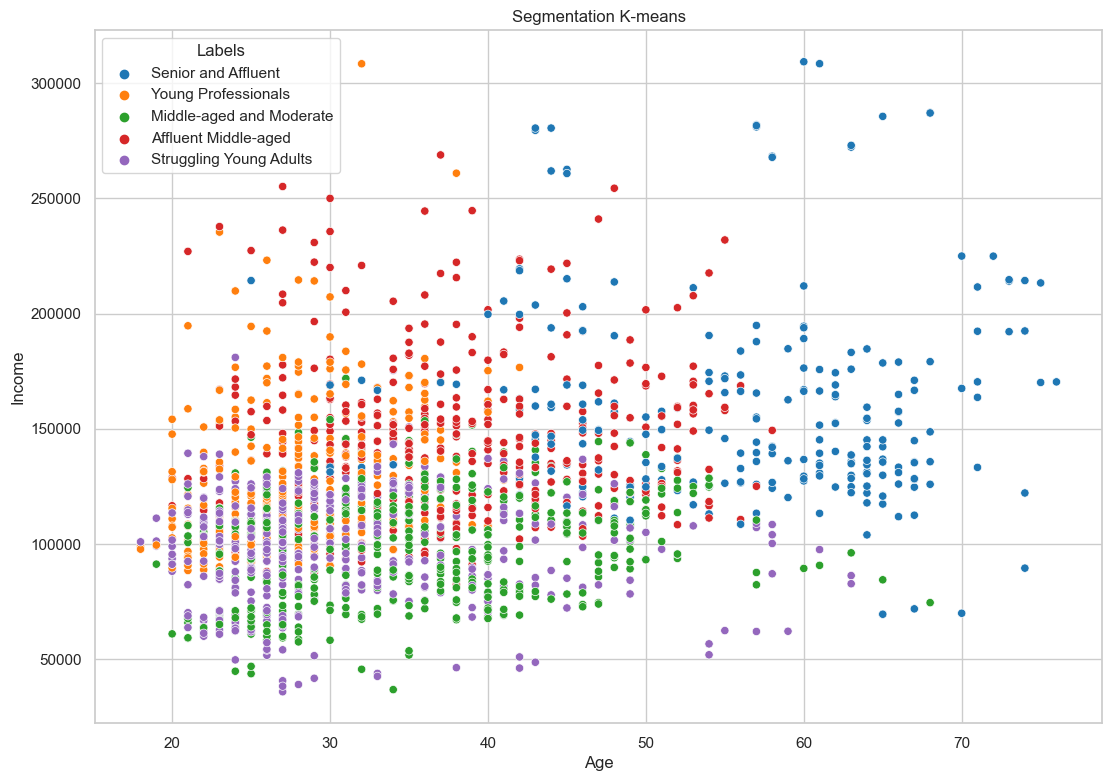

In [16]:
x_axis = df_segm_kmeans['Age']
y_axis = df_segm_kmeans['Income']
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
plt.figure(figsize = (13, 9))
sns.scatterplot(x = x_axis,y =  y_axis, hue = df_segm_kmeans['Labels'], palette = custom_palette)
plt.title('Segmentation K-means')
plt.savefig('../reports/figures/Segment_with_label.png')
plt.show()

### Exploring Data with PCA

After visualizing the clustered data, it appears that there is no clear separation between the clusters, indicating that the original feature space might not be suitable for distinct clustering. In such cases, Principal Component Analysis (PCA) can be a useful technique to transform and simplify the data.

#### What is PCA?

PCA is a dimensionality reduction technique that transforms the original features into a new set of uncorrelated variables called principal components. These components are ranked in order of importance, with the first component explaining the most variance in the data.

#### Purpose of PCA

The main goal of using PCA in this context is to reduce the number of features while retaining the most significant information. By projecting the data onto a lower-dimensional space, PCA can help identify underlying patterns and trends that may not be evident in the original feature space.

#### Benefits of PCA

1. Dimension Reduction: PCA allows us to reduce the complexity of the data by focusing on the most influential components.

2. Visualization: PCA can simplify data visualization by projecting it onto a 2D or 3D space, making it easier to observe patterns and relationships.

3. Noise Reduction: By discarding less important components, PCA can mitigate the impact of noise in the data.

#### Applying PCA

To apply PCA, we will standardize the data (if necessary) and then transform it into a lower-dimensional space using the `PCA` class from the `sklearn.decomposition` module. We can then analyze the results to see if the reduced components provide better insights and clustering results.

Keep in mind that the choice of the number of principal components is crucial and requires careful consideration. It should strike a balance between reducing dimensionality and retaining enough variance to capture meaningful patterns in the data.

In summary, PCA is a valuable tool for exploring and simplifying data when there is no clear separation between clusters. By reducing the feature space and focusing on the most important components, we can potentially gain better insights and understanding of the underlying structure of the data.


### ${\textbf{PCA}}$

In [17]:
pca = PCA()

In [18]:
pca.fit(df_std)

PCA()

In [19]:
cumulative_variance = pca.explained_variance_ratio_.cumsum()
cumulative_variance

array([0.35696328, 0.61947251, 0.80768365, 0.88326115, 0.94042627,
       0.97997421, 1.        ])

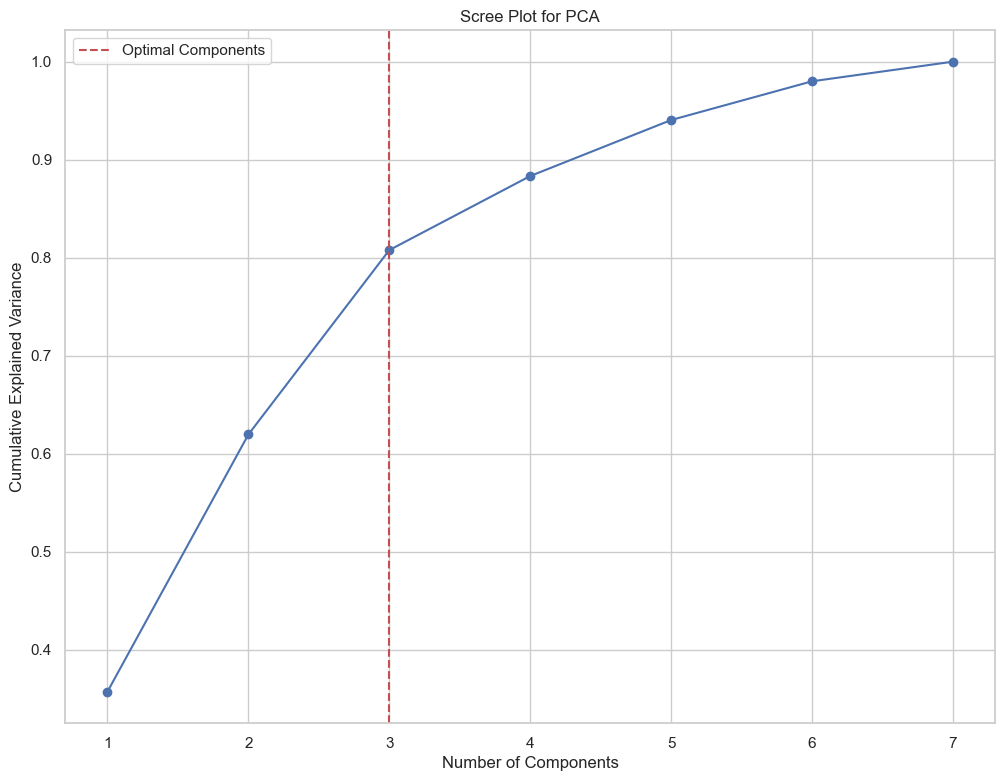

In [20]:

# Plot the scree plot
plt.figure(figsize=(12, 9))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot for PCA')
plt.grid(True)

# Add a vertical line to identify the "elbow" point
plt.axvline(x=3, color='r', linestyle='--', label='Optimal Components')

plt.legend()
plt.savefig('../reports/figures/Explained_var_comp.png')
plt.show()


In [21]:
pca = PCA(n_components = 3)

In [22]:
pca.fit(df_std)

PCA(n_components=3)

### ${\textbf{PCA Results}}$

In [23]:
pca.components_

array([[-0.31469524, -0.19170439,  0.32609979,  0.15684089,  0.52452463,
         0.49205868,  0.46478852],
       [ 0.45800608,  0.51263492,  0.31220793,  0.63980683,  0.12468314,
         0.01465779, -0.06963165],
       [-0.29301261, -0.44197739,  0.60954372,  0.27560461, -0.16566231,
        -0.39550539, -0.29568503]])

In [24]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df.columns.values,
                           index = ['Component 1', 'Component 2', 'Component 3'])
df_pca_comp

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Component 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
Component 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
Component 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


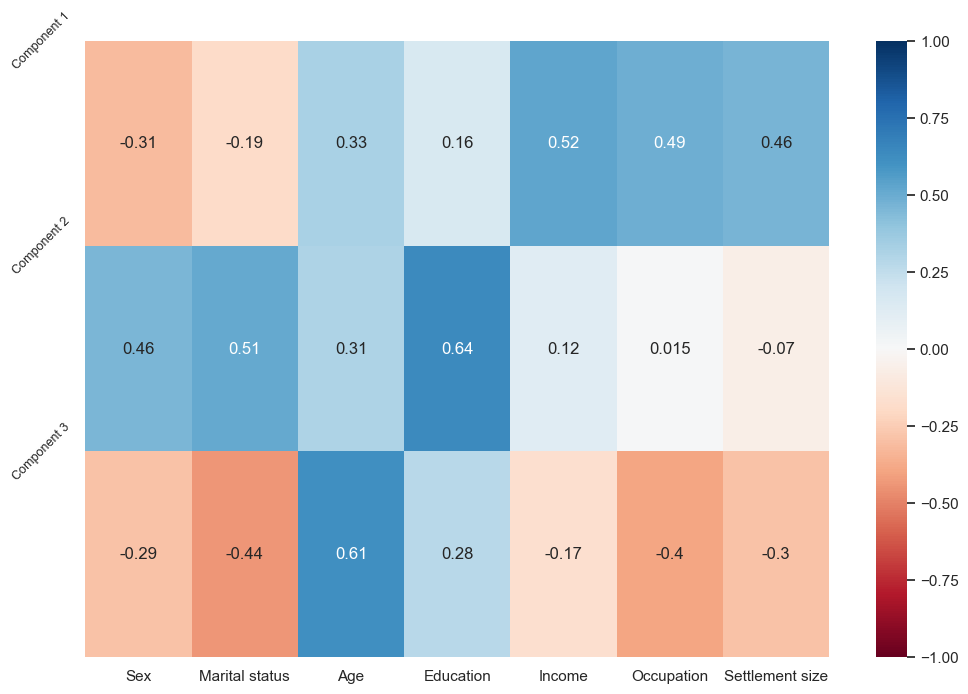

In [25]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_pca_comp,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0, 1, 2], 
           ['Component 1', 'Component 2', 'Component 3'],
           rotation = 45,
           fontsize = 9)
plt.show()

### Principal Component Analysis (PCA) Results

PCA was applied to the standardized dataset to reduce the dimensionality and capture the most significant patterns in the data. The table above shows the loadings of the original features onto the first three principal components.

#### Component 1:
- The first component exhibits strong positive loadings for "Income," "Occupation," and "Settlement size," indicating that it represents an economic and urbanization factor.
- It has moderate positive loadings for "Age" and "Education," suggesting a relation between age, education, and economic status.
- The "Sex" and "Marital status" have small negative loadings, implying a weaker association with this component.

#### Component 2:
- The second component is dominated by positive loadings for "Education" and "Income," indicating a strong link between education level and income.
- "Occupation" and "Marital status" also contribute positively to this component, suggesting their connection to higher education and income.
- "Age" and "Settlement size" have smaller positive loadings, indicating a weaker relationship with this component.

#### Component 3:
- The third component is characterized by strong positive loadings for "Age" and "Occupation," suggesting an association between age and specific occupations.
- "Marital status" has a negative loading, indicating a potential relationship between marital status and the occupation represented by this component.
- "Income" and "Settlement size" have negative loadings, suggesting a weak connection to this component.

In summary, PCA has provided a reduced representation of the dataset with the first three principal components capturing distinct patterns related to economic status, education, and age-related factors. This transformation enables a more straightforward interpretation and visualization of underlying patterns in the data.

In [26]:
pca.transform(df_std)

array([[ 2.51474593,  0.83412239,  2.1748059 ],
       [ 0.34493528,  0.59814564, -2.21160279],
       [-0.65106267, -0.68009318,  2.2804186 ],
       ...,
       [-1.45229829, -2.23593665,  0.89657125],
       [-2.24145254,  0.62710847, -0.53045631],
       [-1.86688505, -2.45467234,  0.66262172]])

In [27]:
scores_pca = pca.transform(df_std)

### ${\textbf{K-means clustering with PCA}}$

In [28]:
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

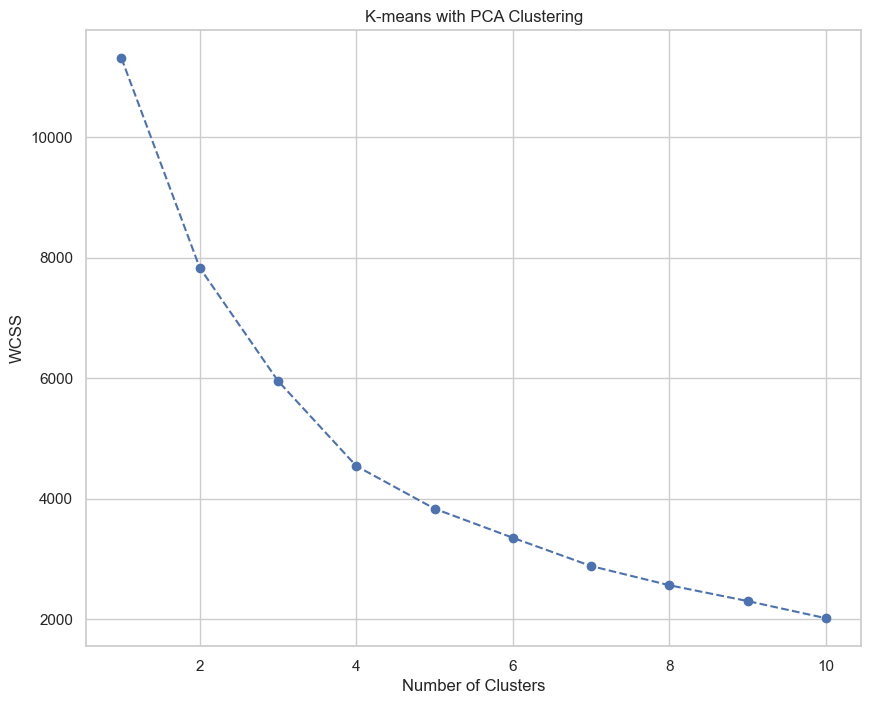

In [29]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.savefig('../reports/figures/kmeans_wcss_pca.png')
plt.show()

In [30]:
kmeans_pca = KMeans(n_clusters = 5, random_state = 42)

In [31]:
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=5, random_state=42)

### ${\textbf{K-means clustering with PCA Results}}$

In [32]:
df_segm_pca_kmeans = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [33]:
df_segm_pca_kmeans

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Segment K-means PCA
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,0
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,3
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,1
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,4
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,4
...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,-0.866034,0.298330,1.438958,2
1996,1,1,27,1,117744,1,0,-1.114957,0.794727,-1.079871,3
1997,0,0,31,0,86400,0,0,-1.452298,-2.235937,0.896571,1
1998,1,1,24,1,97968,0,0,-2.241453,0.627108,-0.530456,2


In [34]:
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3
Segment K-means PCA,,,,,,,,,,
0,0.478088,0.677291,55.764940,2.135458,160996.087649,1.175299,1.147410,1.823165,2.009250,0.816435
1,0.096386,0.000000,34.506024,0.560241,97094.189759,0.346386,0.117470,-0.787654,-1.423233,0.975932
2,0.879487,0.730769,33.787179,1.179487,88644.882051,0.053846,0.000000,-1.829596,0.663303,0.377274
3,0.779439,0.938318,27.915888,1.003738,119174.517757,1.039252,0.768224,-0.436002,0.496823,-1.156412
4,0.004065,0.073171,37.099593,0.725610,144174.142276,1.288618,1.504065,1.525794,-1.130684,-0.116649


In [35]:
cluster_names = {
    3: "Young Professionals",
    2: "Struggling Young Adults",
    1: "Middle-aged and Moderate",
    4: "Affluent Middle-aged",
    0: "Senior and Affluent"
}

In [36]:
df_segm_pca_kmeans_freq['N Obs'] = df_segm_pca_kmeans[['Segment K-means PCA','Sex']].groupby(['Segment K-means PCA']).count()
df_segm_pca_kmeans_freq['Prop Obs'] = df_segm_pca_kmeans_freq['N Obs'] / df_segm_pca_kmeans_freq['N Obs'].sum()
df_segm_pca_kmeans_freq = df_segm_pca_kmeans_freq.rename(cluster_names)
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,N Obs,Prop Obs
Segment K-means PCA,,,,,,,,,,,,
Senior and Affluent,0.478088,0.677291,55.764940,2.135458,160996.087649,1.175299,1.147410,1.823165,2.009250,0.816435,251,0.1255
Middle-aged and Moderate,0.096386,0.000000,34.506024,0.560241,97094.189759,0.346386,0.117470,-0.787654,-1.423233,0.975932,332,0.1660
Struggling Young Adults,0.879487,0.730769,33.787179,1.179487,88644.882051,0.053846,0.000000,-1.829596,0.663303,0.377274,390,0.1950
Young Professionals,0.779439,0.938318,27.915888,1.003738,119174.517757,1.039252,0.768224,-0.436002,0.496823,-1.156412,535,0.2675
Affluent Middle-aged,0.004065,0.073171,37.099593,0.725610,144174.142276,1.288618,1.504065,1.525794,-1.130684,-0.116649,492,0.2460


In [37]:
df_segm_pca_kmeans['Legend'] = df_segm_pca_kmeans['Segment K-means PCA'].map(cluster_names)

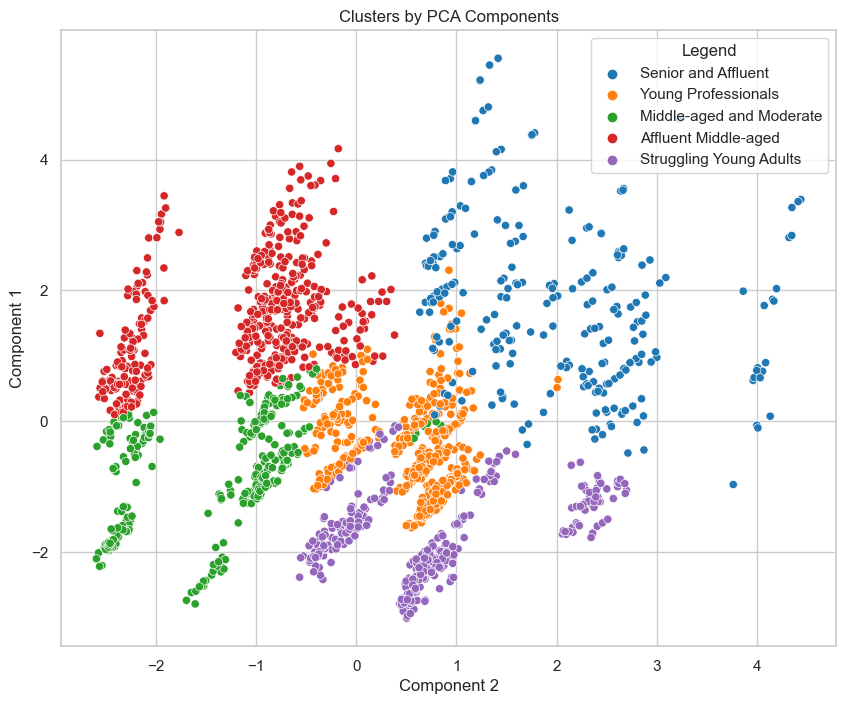

In [38]:
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
z_axis = df_segm_pca_kmeans['Component 3']

plt.figure(figsize = (10, 8))
sns.scatterplot(x = x_axis,y =  y_axis, hue = df_segm_pca_kmeans['Legend'], palette = custom_palette)
plt.title('Clusters by PCA Components')
plt.savefig('../reports/figures/clusters_pca_com.png')
plt.show()

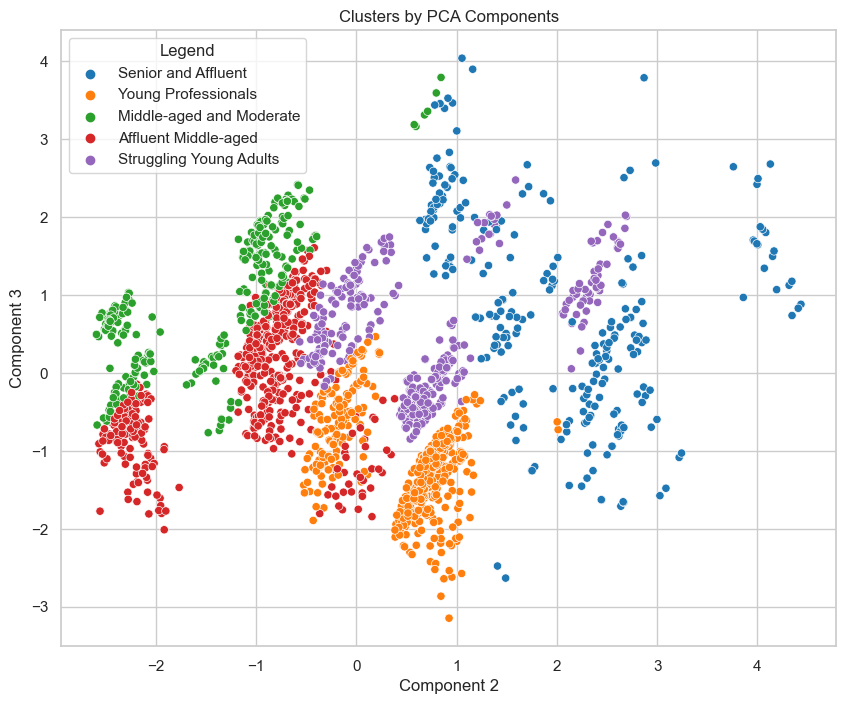

In [39]:
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
z_axis = df_segm_pca_kmeans['Component 3']

plt.figure(figsize = (10, 8))
sns.scatterplot(x = x_axis,y = z_axis, hue = df_segm_pca_kmeans['Legend'], palette = custom_palette)
plt.title('Clusters by PCA Components')
plt.show()

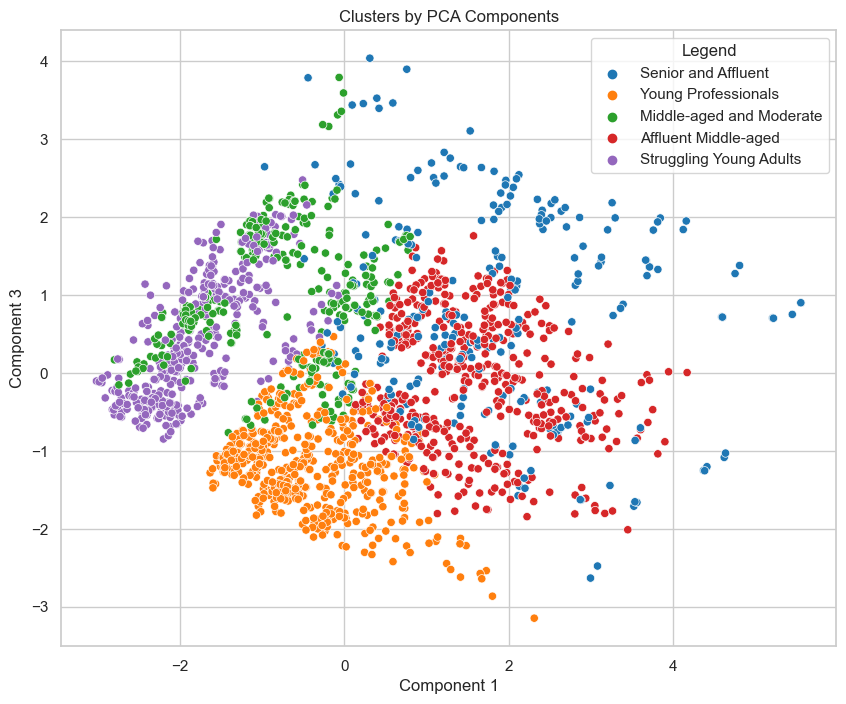

In [40]:
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
z_axis = df_segm_pca_kmeans['Component 3']

plt.figure(figsize = (10, 8))
sns.scatterplot(x = y_axis,y =  z_axis, hue = df_segm_pca_kmeans['Legend'], palette = custom_palette)
plt.title('Clusters by PCA Components')
plt.show()

In [41]:
df_segm_pca_kmeans.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Segment K-means PCA,Legend
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,0,Senior and Affluent
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,3,Young Professionals
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,1,Middle-aged and Moderate
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,4,Affluent Middle-aged
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,4,Affluent Middle-aged


In [42]:

fig = px.scatter_3d(df_segm_pca_kmeans, x=x_axis, y= y_axis, z=z_axis,
                    color= df_segm_pca_kmeans.Legend, color_discrete_sequence=custom_palette)

fig.update_layout(title='Clusters by PCA Components - 3D Scatter Plot',
                  scene=dict(xaxis_title='Component 2', yaxis_title='Component 1', zaxis_title='Component 3'))

pio.write_html(fig, file='../reports/figures/3D_scatter_plot.html')

fig.show()


In [48]:
df_segm_pca_kmeans.to_csv('../data/processed/segm_pca_kmeans.csv', index = False)

In [43]:
with open('../models/scaler.pickle', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)


In [44]:
with open('../models/pca.pickle', 'wb') as pca_file:
    pickle.dump(pca, pca_file)


In [45]:
with open('../models/kmeans.pickle', 'wb') as kmeans_file:
    pickle.dump(kmeans_pca, kmeans_file)
